# Process gridded CMIP6 model data into variability data

__1. Process the gridded temperature data into timeseries for each model.__

Resample for time periods 2-120 years (to compare with 1900-2023 observations) to generate envelopes of internal variability for each region and each model.  

- Output is a dataArray for each model with indexed by time period length (3-120 years) and IPCC region containing a 95% confidence interval on unforced TAS trends.


Nathan notes that these models do the best job in CONUS:  MPI-ESM, GFDL-ESM2M, CESM1-CAM5, CanESM2.

For now, I will create my code for the CESM1 and MPI models so that it can be generalized easily. I can pull some code from my climatetrend_uncertainty repository (climatetrend_uncertainty/initial_code/PIC_timeseries_preproc.ipynb).

## Code!

In [50]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

%matplotlib inline

__Processed Data directory:__  

Time series of TAS for each IPCC region.

In [51]:
pic_tseries_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/'

#### Collect CESM1 PIC file paths.

In [52]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

In [53]:
cesm1_dir = 'CESM1/'

cesm1_pic_tas_files = glob.glob('%s/%s/*%s.?????????????.nc' % (pic_tseries_dir,cesm1_dir,cesm1_cmor_var_dict['tas']))
cesm1_pic_tas_files.sort()

In [54]:
mpi_dir = 'MPI-GE/'

mpi_pic_tas_files = glob.glob('%s/%s/*%s*r001i1850p3_??????-??????.nc' % (pic_tseries_dir,mpi_dir,'tas'))
mpi_pic_tas_files.sort()

In [55]:
canesm2_dir = 'CanESM2/'

canesm2_pic_tas_files = glob.glob('%s/%s/*%s*r1i1p1_??????-??????.nc' % (pic_tseries_dir,canesm2_dir,'tas'))
canesm2_pic_tas_files.sort()

In [56]:
esm2m_dir = 'ESM2M/'

esm2m_pic_tas_files = glob.glob('%s/%s/*%s*r1i1p1_??????-??????.nc' % (pic_tseries_dir,esm2m_dir,'tas'))
esm2m_pic_tas_files.sort()

### Process time series into unforced trends as a function of trend duration

Using code from:  

trend_uncertainty/PIC_trend_preproc.ipynb

__Define functions:__

In [57]:
def get_trends_allstartyears(data,duration,startyears,dim='year'):
    '''
    Calculate: 
    a. trends of a given duration
    '''
    
    description = 'Trends for an unforced Pre-Industrial Control simulation sampled by timeseries startyear and duration.'
    
    # Initialize list to save to
    trends_list = []
    
    for i,startyear in enumerate(startyears):
        
        _startyr = startyear
        _endyr   = startyear + duration - 1

        _tsel = data.sel(year=slice(_startyr,_endyr)) # index differently here because the dates are different

        # Calculate the slope        
        _tsel_polyfit = _tsel.polyfit(dim=dim,deg=1)['polyfit_coefficients'].sel(degree=1)
        _tsel_slopes  = _tsel_polyfit.drop('degree')
        
        trends_list.append(_tsel_slopes.assign_coords({'startyear':startyear}).expand_dims('startyear'))
        
    out = xr.concat(trends_list,dim='startyear').assign_coords({'duration':duration}).expand_dims('duration')
        
    return out

In [58]:
def compute_trends_wrapper(data,durations=np.arange(5,81,),**kwargs):
    '''
    Wrapper for running 'get_allvar_allstartyears' for different durations.
    Setup with correct startyears and concatenate at the end.
    '''
    
    first_year = data['year'][0]
    last_year  = data['year'][-1]

    trends_allstartyear_allduration_list = []

    for duration in durations:
        print(duration,end=' ')
        _startyears = np.arange(first_year,last_year+2-duration,1)

        allvar_onedur_ds = get_trends_allstartyears(data,
                                                    duration=duration,
                                                    startyears=_startyears,
                                                    **kwargs
                                                   )
        
        trends_allstartyear_allduration_list.append(allvar_onedur_ds)
        
    trends_allstartyear_allduration_ds = xr.concat(trends_allstartyear_allduration_list,dim='duration')
        
    # Add metadata
    trends_allstartyear_allduration_ds = trends_allstartyear_allduration_ds.assign_coords({"RegionName":   ("RegionIndex", data.RegionName)})
    trends_allstartyear_allduration_ds = trends_allstartyear_allduration_ds.assign_coords({"RegionAbbrev": ("RegionIndex", data.RegionAbbrev)})

    trends_allstartyear_allduration_ds.name = 'TAS_trends'
    
    return trends_allstartyear_allduration_ds

### Compute trends for all durations and save

#### CESM1-LE

Shifting the months up by one so that December fills the spot of January. Then I want to average in a way that masks if a nan is present.

In [59]:
cesm1_pic_tas_ds = xr.open_mfdataset(cesm1_pic_tas_files,chunks={'RegionIndex':1})

In [60]:
%%time

cesm1_pic_tas_ensoshift = cesm1_pic_tas_ds[cesm1_cmor_var_dict['tas']].shift(time=1).groupby('time.year').mean(dim='time',skipna=False)

cesm1_pic_tas_annual_ensoshift = cesm1_pic_tas_ensoshift.mean(dim='time',skipna=False).isel(year=slice(1,None)).compute()

ValueError: 'time' not found in array dimensions ('year', 'RegionIndex')

In [61]:
cesm1_pic_tas_ds

<xarray.Dataset>
Dimensions:       (RegionIndex: 58, time: 21612)
Coordinates:
    RegionName    (RegionIndex) object dask.array<chunksize=(1,), meta=np.ndarray>
    RegionAbbrev  (RegionIndex) object dask.array<chunksize=(1,), meta=np.ndarray>
  * RegionIndex   (RegionIndex) int64 0 1 2 3 4 5 6 7 ... 51 52 53 54 55 56 57
  * time          (time) object 0400-01-01 00:00:00 ... 2200-12-01 00:00:00
Data variables:
    TREFHT        (time, RegionIndex) float64 dask.array<chunksize=(1200, 1), meta=np.ndarray>

In [62]:
shift_ex = cesm1_pic_tas_ds['TREFHT'].shift(time=1)

In [63]:
# skipna=False so we don't accidentally include years with a nan/11 months
test_shifted_annual_mean = shift_ex.groupby('time.year').mean(dim='time',skipna=False)

In [64]:
ex_reg0 = test_shifted_annual_mean.isel(RegionIndex=0).compute()

In [65]:
ex_reg0.isel(year=slice(1,None)) #.dropna(dim='time')

<xarray.DataArray 'TREFHT' (year: 1800)>
array([257.87757233, 258.60939942, 260.73121031, ..., 258.93509138,
       259.90710454, 260.81277017])
Coordinates:
    RegionName    <U17 'Greenland/Iceland'
    RegionAbbrev  <U3 'GIC'
    RegionIndex   int64 0
  * year          (year) int64 401 402 403 404 405 ... 2196 2197 2198 2199 2200

In [66]:
cesm1_pic_tas_ds.time

<xarray.DataArray 'time' (time: 21612)>
array([cftime.DatetimeNoLeap(400, 1, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(400, 2, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(400, 3, 1, 0, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2200, 10, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2200, 11, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2200, 12, 1, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 0400-01-01 00:00:00 ... 2200-12-01 00:00:00
Attributes:
    long_name:  time interval endpoints

In [67]:
ex_reg0 = test_shifted_annual_mean.isel(RegionIndex=0).mean(dim='year',skipna=False)

In [68]:
%%time

norm_data     = cesm1_pic_tas_ds['TREFHT'].isel(RegionIndex=0,time=slice(None,30)).compute()
shift_ex_data = shift_ex.isel(RegionIndex=0,time=slice(None,30)).compute()

CPU times: user 52.6 ms, sys: 3.95 ms, total: 56.6 ms
Wall time: 66.1 ms


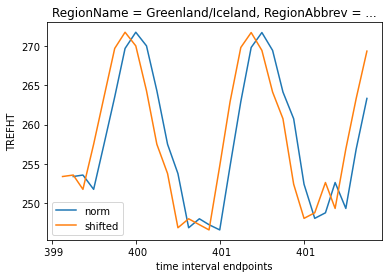

In [69]:
shift_ex_data.plot(label='norm')
norm_data.plot(label='shifted')

plt.legend()

Standard calendar year definition (January through December).

In [70]:
%%time

# Compute annual average
cesm1_pic_tas_annual = cesm1_pic_tas_ds[cesm1_cmor_var_dict['tas']].groupby('time.year').mean('time')

cesm1_pic_tas_annual = cesm1_pic_tas_annual.compute()

CPU times: user 37.3 s, sys: 3.32 s, total: 40.6 s
Wall time: 43.4 s


In [71]:
%%time

cesm1_pic_tas_ensoshift = cesm1_pic_tas_ds[cesm1_cmor_var_dict['tas']].shift(time=1).groupby('time.year').mean(dim='time',skipna=False)

cesm1_pic_tas_annual_ensoshift = cesm1_pic_tas_ensoshift.isel(year=slice(1,None)).compute()

CPU times: user 41.6 s, sys: 2.95 s, total: 44.6 s
Wall time: 47.9 s


We see a small difference in the Greenland Area when the different sampling techniques are used.

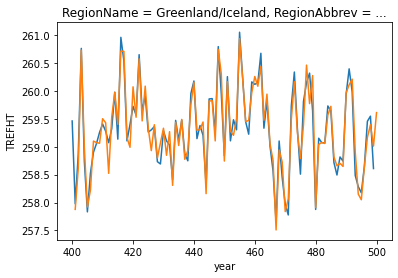

In [72]:
cesm1_pic_tas_annual.isel(RegionIndex=0,year=slice(None,100)).plot()

cesm1_pic_tas_annual_ensoshift.isel(RegionIndex=0,year=slice(None,100)).plot()

I see a small difference Equatorial Pacific too. So maybe this effect doesn't matter? At least for this model and its representation of ENSO?

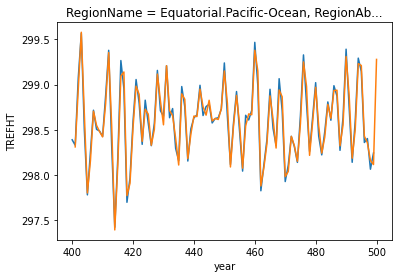

In [73]:
cesm1_pic_tas_annual.isel(RegionIndex=48,year=slice(None,100)).plot()

cesm1_pic_tas_annual_ensoshift.isel(RegionIndex=48,year=slice(None,100)).plot()

In [74]:
%%time

cesm1_pic_trends_all = compute_trends_wrapper(cesm1_pic_tas_annual,durations=np.arange(3,122,1))

3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 CPU times: user 11min 32s, sys: 1.22 s, total: 11min 33s
Wall time: 12min 24s


~12 minutes is totally reasonable!

In [75]:
cesm1_pic_trends_all.to_netcdf('%s/%s/b.e11.B1850C5CN.f09_g16.005.cam.h0.TREFHT.1900trends.040001-220012.nc' % (pic_tseries_dir,cesm1_dir))

In [76]:
cesm1_pic_trends_all = xr.open_dataset('%s/%s/b.e11.B1850C5CN.f09_g16.005.cam.h0.TREFHT.1900trends.040001-220012.nc' % (pic_tseries_dir,cesm1_dir))

In [77]:
%%time

cesm1_pic_ensoshift_trends_all = compute_trends_wrapper(cesm1_pic_tas_annual_ensoshift,durations=np.arange(3,122,1))

3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 CPU times: user 11min 30s, sys: 1.28 s, total: 11min 32s
Wall time: 12min 23s


In [78]:
cesm1_pic_ensoshift_trends_all.to_netcdf('%s/%s/b.e11.B1850C5CN.f09_g16.005.cam.h0.TREFHT.ENSOshift_1900trends.040001-220012.nc' % (pic_tseries_dir,cesm1_dir))

In [79]:
cesm1_shift_data_reg0  = cesm1_pic_ensoshift_trends_all.sel(RegionIndex=0).std(dim='startyear')
cesm1_shift_data_reg48 = cesm1_pic_ensoshift_trends_all.sel(RegionIndex=48).std(dim='startyear')

cesm1_data_reg0  = cesm1_pic_trends_all.sel(RegionIndex=0).std(dim='startyear')
cesm1_data_reg48 = cesm1_pic_trends_all.sel(RegionIndex=48).std(dim='startyear')

__Plot the two sampling methods.__ 

RESULT: Resampling in this way has no discernable structural effect on the variability.

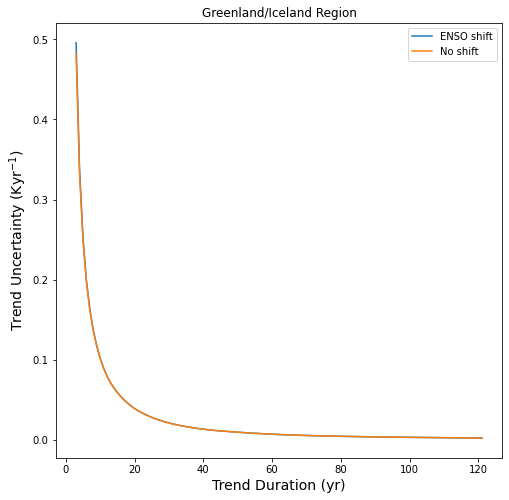

In [80]:
fig,ax = plt.subplots(1,1,figsize=(8,8))

cesm1_shift_data_reg0.plot(label='ENSO shift')
cesm1_data_reg0['TAS_trends'].plot(label='No shift')

ax.set_ylabel('Trend Uncertainty (Kyr$^{-1}$)',fontsize=14)
ax.set_xlabel('Trend Duration (yr)',fontsize=14)

ax.set_title('Greenland/Iceland Region')

plt.legend()

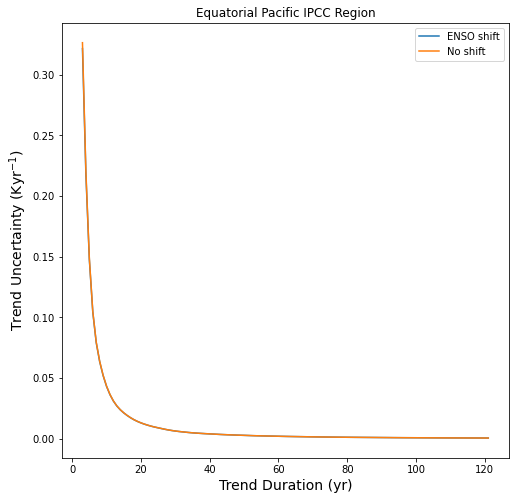

In [81]:
fig,ax = plt.subplots(1,1,figsize=(8,8))

cesm1_shift_data_reg48.plot(label='ENSO shift')
cesm1_data_reg48['TAS_trends'].plot(label='No shift')

ax.set_ylabel('Trend Uncertainty (Kyr$^{-1}$)',fontsize=14)
ax.set_xlabel('Trend Duration (yr)',fontsize=14)

ax.set_title('Equatorial Pacific IPCC Region')

plt.legend()

In [82]:
((cesm1_shift_data_reg48 - cesm1_data_reg48['TAS_trends']) / cesm1_shift_data_reg48).mean(dim='duration')

<xarray.DataArray 'TAS_trends' ()>
array(-0.0023511)
Coordinates:
    RegionIndex   int64 48
    RegionName    object 'Equatorial.Pacific-Ocean'
    RegionAbbrev  object 'EPO'

In [83]:
((cesm1_shift_data_reg0 - cesm1_data_reg0['TAS_trends']) / cesm1_shift_data_reg0).mean(dim='duration')

<xarray.DataArray 'TAS_trends' ()>
array(0.00235523)
Coordinates:
    RegionIndex   int64 0
    RegionName    object 'Greenland/Iceland'
    RegionAbbrev  object 'GIC'

Fix my error swapping the Region names and abbreviations.

In [84]:
# cesm1_pic_trends_all2 = cesm1_pic_trends_all.assign_coords({"RegionName":     ("RegionIndex", cesm1_pic_tas_ds.RegionAbbrev)})
# cesm1_pic_trends_all2 = cesm1_pic_trends_all2.assign_coords({"RegionAbbrev":  ("RegionIndex", cesm1_pic_tas_ds.RegionName)})

# cesm1_pic_trends_all2.name = 'TAS_trends'

# cesm1_pic_trends_all2.to_netcdf('%s/%s/b.e11.B1850C5CN.f09_g16.005.cam.h0.TREFHT.trends.040001-220012.nc' % (pic_tseries_dir,cesm1_dir))

#### MPI-GE

In [85]:
mpi_pic_tas_ds = xr.open_mfdataset(mpi_pic_tas_files,chunks={'RegionIndex':1},use_cftime=True)

In [86]:
%%time

# Compute annual average
mpi_pic_tas_annual = mpi_pic_tas_ds['tas'].groupby('time.year').mean('time')

mpi_pic_tas_annual = mpi_pic_tas_annual.compute()

CPU times: user 41.4 s, sys: 3.63 s, total: 45 s
Wall time: 48.6 s


In [87]:
%%time

mpi_pic_trends_all = compute_trends_wrapper(mpi_pic_tas_annual,durations=np.arange(3,122,1))

3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 CPU times: user 12min 55s, sys: 1.78 s, total: 12min 57s
Wall time: 13min 55s


In [88]:
mpi_pic_trends_all.to_netcdf('%s/%s/tas_Amon_MPI-ESM_piControl_r001i1850p3.1900trends.185001-385012.nc' % (pic_tseries_dir,mpi_dir))

In [89]:
del mpi_pic_trends_all,mpi_pic_tas_annual,mpi_pic_tas_ds

#### CanESM2

In [90]:
canesm2_pic_tas_ds = xr.open_mfdataset(canesm2_pic_tas_files,chunks={'RegionIndex':1},use_cftime=True)

In [91]:
%%time

# Compute annual average
canesm2_pic_tas_annual = canesm2_pic_tas_ds['tas'].groupby('time.year').mean('time')

canesm2_pic_tas_annual = canesm2_pic_tas_annual.compute()

CPU times: user 21 s, sys: 1.75 s, total: 22.8 s
Wall time: 24.2 s


In [92]:
%%time

canesm2_pic_trends_all = compute_trends_wrapper(canesm2_pic_tas_annual,durations=np.arange(3,122,1))

3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 CPU times: user 6min 8s, sys: 702 ms, total: 6min 9s
Wall time: 6min 37s


In [93]:
canesm2_pic_trends_all.to_netcdf('%s/%s/tas_Amon_CanESM2_piControl_r1i1p1.1900trends.201501-301012.nc' % (pic_tseries_dir,canesm2_dir))

#### ESM2M

In [94]:
esm2m_pic_tas_ds = xr.open_mfdataset(esm2m_pic_tas_files,chunks={'RegionIndex':1},use_cftime=True)

In [95]:
%%time

# Compute annual average
esm2m_pic_tas_annual = esm2m_pic_tas_ds['tas'].groupby('time.year').mean('time')

esm2m_pic_tas_annual = esm2m_pic_tas_annual.compute()

CPU times: user 17.7 s, sys: 1.08 s, total: 18.8 s
Wall time: 20 s


In [96]:
%%time

esm2m_pic_trends_all = compute_trends_wrapper(esm2m_pic_tas_annual,durations=np.arange(3,122,1))

3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 CPU times: user 2min 53s, sys: 400 ms, total: 2min 53s
Wall time: 3min 6s


In [97]:
esm2m_pic_trends_all.to_netcdf('%s/%s/tas_Amon_GFDL-ESM2M_piControl_r1i1p1.1900trends.000101-050012.nc' % (pic_tseries_dir,esm2m_dir))